In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/calls_weather_tfk.csv')

In [3]:
# NOTE: features[N:M] actually is features[N] through features [M-1] -- it's non-inclusive

# features[0]       --- 'CAD_INCIDENT_ID'                                            ---- DROP (only an index)
# features[1]       --- 'INITIAL_SEVERITY_LEVEL_CODE'
# features[2]       --- 'FINAL_SEVERITY_LEVEL_CODE'
# features[3]       --- 'FIRST_ASSIGNMENT_DATETIME'                                  ---- DROP
# features[4]       --- 'VALID_DISPATCH_RSPNS_TIME_INDC' 
# features[5]       --- 'DISPATCH_RESPONSE_SECONDS_QY'                               ---- DROP
# features[6]       --- 'FIRST_ACTIVATION_DATETIME' 
# features[7]       --- 'VALID_INCIDENT_RSPNS_TIME_INDC'
# features[8]       --- 'INCIDENT_RESPONSE_SECONDS_QY'                               ------> y
# features[9]       --- 'INCIDENT_TRAVEL_TM_SECONDS_QY'
# features[10]      --- 'INCIDENT_CLOSE_DATETIME' 
# features[11]      --- 'HELD_INDICATOR' 
# features[12]      --- 'REOPEN_INDICATOR'
# features[13]      --- 'SPECIAL_EVENT_INDICATOR' 
# features[14]      --- 'STANDBY_INDICATOR'
# features[15]      --- 'TRANSFER_INDICATOR'
# features[16:96]   --- 'INITIAL_CALL_TYPE' dummies
# features[96:186]  --- 'FINAL_CALL_TYPE' dummies
# features[186:195] --- 'INCIDENT_DISPOSITION_CODE' dummies
# features[195:198] --- 'BOROUGH' dummies
# features[198:230] --- 'INCIDENT_DISPATCH_AREA' dummies
# features[230:594] --- 'ZIPCODE' dummies
# features[594:670] --- 'POLICEPRECINCT' dummies
# features[670:720] --- 'CITYCOUNCILDISTRICT' dummies
# features[720:788] --- 'COMMUNITYDISTRICT' dummies
# features[788:819] --- 'COMMUNITYSCHOOLDISTRICT' dummies
# features[829:831] --- 'CONGRESSIONALDISTRICT' dummies
# features[831]     --- 'CALL_YEAR'
# features[832]     --- 'CALL_DAY'
# features[833]     --- 'CALL_TIME'
# features[834]     --- 'CALL_UTC'
# features[835:846] --- 'CALL_MONTH' dummies
# features[846]     --- 'CALL_MONTH' (numeric)
# features[847]     --- 'AWIND'
# features[848]     --- 'PRCP'
# features[849]     --- 'SNOW'
# features[850]     --- 'SNWD'
# features[851]     --- 'TMAX'
# features[852]     --- 'TMIN'
# features[853]     --- 'TAVG_CALC'

In [4]:
df['num_calls'].describe()

count    25465.000000
mean       136.328569
std         54.236394
min          3.000000
25%         88.000000
50%        128.000000
75%        184.000000
max        429.000000
Name: num_calls, dtype: float64

In [5]:
df.columns

Index(['Unnamed: 0', 'year', 'month', 'day', 'hour', 'num_calls', 'BRONX',
       'BROOKLYN', 'MANHATTAN', 'QUEENS', 'RICHMOND / STATEN ISLAND',
       'UNKNOWN', 'STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD',
       'TMAX', 'TMIN', 'TAVG_CALC', 'Incidences'],
      dtype='object')

In [6]:
features = ['Unnamed: 0', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 
            'RICHMOND / STATEN ISLAND', 'UNKNOWN', 'NAME', 'num_calls', 'DATE']


X = df.drop(columns= features)

X = X.fillna(X['AWND'].mean())

X = pd.get_dummies(data = X, columns = ['STATION'], drop_first = True)

y = df['num_calls']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)



In [7]:
X.columns

Index(['year', 'month', 'day', 'hour', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'TAVG_CALC', 'Incidences'],
      dtype='object')

In [9]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [71]:
linreg = LinearRegression()

linreg.fit(X_train_sc, y_train)

print(f'Training: {linreg.score(X_train_sc, y_train)}')
print(f'Testing: {linreg.score(X_test_sc, y_test)}')

Training: 0.5144276829337519
Testing: 0.5188483809790554


This does not seem likely, not sure yet why this is the result but there is definitely something not quite right here.

In [72]:
lasso = Lasso(max_iter = 10_000)

lasso.fit(X_train_sc, y_train)

print(f'Training: {lasso.score(X_train_sc, y_train)}')
print(f'Testing: {lasso.score(X_test_sc, y_test)}')

Training: 0.5120454233455058
Testing: 0.5163948752009309


In [73]:
ridge = Ridge()

ridge.fit(X_train_sc, y_train)

print(f'Training: {ridge.score(X_train_sc, y_train)}')
print(f'Testing: {ridge.score(X_test_sc, y_test)}')

Training: 0.5144276816478912
Testing: 0.5188484599641534


**I realized the issue here.  Left in a lot of data that was used to create our new dependent variable.  This has been corrected more or less.**

### **Lets Try Neural Nets.  The Thinking Persons Artificial Thinker.**

In [10]:
X_train_sc.shape

(19098, 12)

In [11]:
# making no changes, I want the NNet baseline
# Insert model here...
model = Sequential()

model.add(Dense(32, activation = 'relu', input_shape = (12,)))
model.add(Dense(32, activation = 'relu'))

model.add(Dense(1, activation = None))

#compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

# fit the model
results = model.fit(X_train_sc, y_train,
                    batch_size = 100,
                    epochs = 100, 
                    validation_data = (X_test_sc, y_test),
                    verbose = 0)



In [12]:
results.history['mae'][-1]

17.53898048400879

In [13]:
results.history['val_mae'][-1]

17.298696517944336

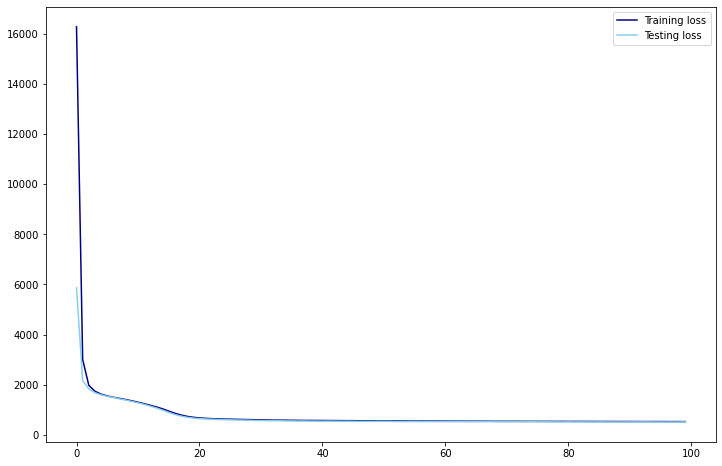

In [14]:
# Visualize the loss
train_loss = results.history['loss']
test_loss =  results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [ ]:
train_mae = results.history['mae']
test_mae =  results.history['val_mae']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training MAE', color='navy')
plt.plot(test_mae, label='Testing MAE', color='skyblue')
plt.legend();

# **ALL MODELS BEFORE THIS POINT WERE RUN WITHOUT OUR TRAFFIC DATA**

In [48]:
# the below DF is with scaling

las_coef = pd.read_csv('data/lasso_coefs.csv')

In [49]:
las_coef.sort_values(by ='coefficients', inplace = True)

In [50]:
las_coef

,Unnamed: 0,features,coefficients
253,253,POLICEPRECINCT_46.0,-5.956488
316,316,CALL_MONTH_SEP,-3.338527
116,116,FINAL_CALL_TYPE_DRUG,-1.919331
134,134,FINAL_CALL_TYPE_JUMPUP,-1.663440
74,74,INITIAL_CALL_TYPE_RESPIR,-1.239991
...,...,...,...
118,118,FINAL_CALL_TYPE_EDP,5.272286
189,189,INCIDENT_DISPOSITION_CODE_96.0,6.095546
7,7,HELD_INDICATOR,88.182371
3,3,FIRST_ACTIVATION_DATETIME,193.018453


In [51]:
forest = RandomForestRegressor(n_estimators = 1_000)

forest.fit(X_train_sc, y_train)

print(f'Training: {forest.score(X_train_sc, y_train)}')
print(f'Testing: {forest.score(X_test_sc, y_test)}')

Training: 0.9769031121202865
Testing: 0.8373684058135169


In [53]:
new_df = pd.read_csv('data/hourlycounts_through2019.csv')

new_df.head()

,Unnamed: 0,Unnamed: 0.1,year,month,day,hour,num_calls,BRONX,BROOKLYN,MANHATTAN,QUEENS,RICHMOND / STATEN ISLAND,UNKNOWN
0,0,0,2010,1,1,1,347,60,80,153,45,9,0
1,1,1,2010,1,1,2,318,75,83,93,58,9,0
2,2,2,2010,1,1,3,262,63,62,85,45,7,0
3,3,3,2010,1,1,4,281,63,69,90,52,7,0
4,4,4,2010,1,1,5,201,55,55,48,39,4,0


In [54]:
X = new_df.drop(columns = 'num_calls')
y = new_df['num_calls']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [55]:
X_train_sc.shape

(65723, 12)

In [57]:
stop = EarlyStopping(monitor = 'mae', patience = 10, min_delta = 1)

# set up structure
model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape = (12,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = None))

# compile
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

results = model.fit(X_train_sc, y_train, 
          epochs = 100,
          batch_size = 256,
          validation_data = (X_test_sc, y_test),
          callbacks = stop,
                   verbose = 1)

Epoch 1/100
257/257 [==============================] - 1s 3ms/step - loss: 16212.1527 - mae: 104.7460 - val_loss: 572.4463 - val_mae: 18.7991
Epoch 2/100
257/257 [==============================] - 1s 2ms/step - loss: 504.3864 - mae: 16.9503 - val_loss: 245.7756 - val_mae: 12.3343
Epoch 3/100
257/257 [==============================] - 1s 2ms/step - loss: 204.0225 - mae: 10.4180 - val_loss: 54.3487 - val_mae: 5.6453
Epoch 4/100
257/257 [==============================] - 1s 2ms/step - loss: 42.8293 - mae: 4.5565 - val_loss: 13.5287 - val_mae: 2.5689
Epoch 5/100
257/257 [==============================] - 1s 2ms/step - loss: 11.2387 - mae: 2.3573 - val_loss: 7.8942 - val_mae: 1.8621
Epoch 6/100
257/257 [==============================] - 1s 2ms/step - loss: 10.5221 - mae: 1.8128 - val_loss: 5.5552 - val_mae: 1.5298
Epoch 7/100
257/257 [==============================] - 1s 2ms/step - loss: 5.2929 - mae: 1.4705 - val_loss: 4.4279 - val_mae: 1.2877
Epoch 8/100
257/257 [=========================

In [ ]:
results.history['mae'][-1]


In [37]:
new_df

,Unnamed: 0,index,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,...,TMAX,TMIN,TAVG_CALC,Borough,County,year,month,day,hour,Incidences
0,0,77,110241339,4,4,19.0,1,19,30.0,1,...,24.0,6.0,15.0,Manhattan,Manhattan,2011,1,24,10,1
1,1,84,110261612,3,3,44.0,1,44,51.0,1,...,35.0,30.0,32.5,Brooklyn,Brooklyn,2011,1,26,11,1
2,2,107,110340066,4,4,14.0,1,14,26.0,1,...,34.0,24.0,29.0,Manhattan,Manhattan,2011,2,3,12,1
3,3,108,110341185,4,4,68.0,1,68,75.0,1,...,34.0,24.0,29.0,Bronx,Bronx,2011,2,3,10,1
4,4,124,110591028,7,7,1575.0,1,1575,1589.0,1,...,60.0,40.0,50.0,Bronx,Bronx,2011,2,28,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,10924,103071018,4,4,397.0,1,397,452.0,1,...,54.0,41.0,47.5,Manhattan,Manhattan,2010,11,3,9,1
1848,1848,10969,103210246,6,6,25.0,1,25,42.0,1,...,60.0,51.0,55.5,Bronx,Bronx,2010,11,17,2,1
1849,1849,10992,103280663,5,5,35.0,1,35,53.0,1,...,50.0,41.0,45.5,Brooklyn,Brooklyn,2010,11,24,7,1
1850,1850,11007,103330127,3,3,15.0,1,15,24.0,1,...,48.0,35.0,41.5,Bronx,Bronx,2010,11,29,1,1


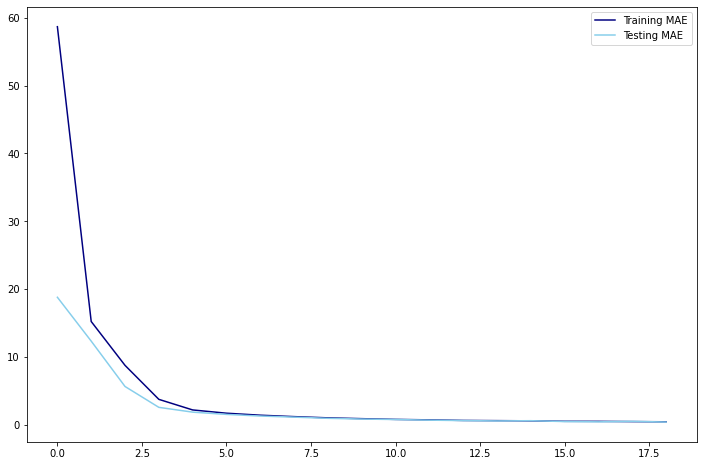

In [58]:
train_mae = results.history['mae']
test_mae =  results.history['val_mae']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training MAE', color='navy')
plt.plot(test_mae, label='Testing MAE', color='skyblue')
plt.legend();

In [59]:
results.history['mae'][-1]

0.4407203197479248

In [60]:
results.history['mae'][-1]

0.4407203197479248

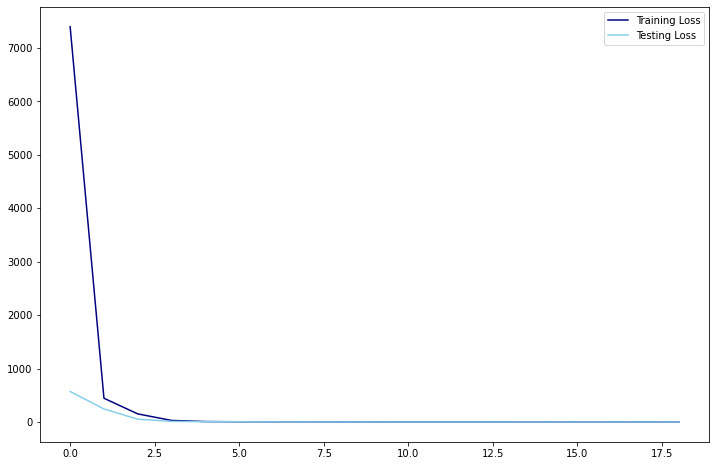

In [61]:
train_mae = results.history['loss']
test_mae =  results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_mae, label='Training Loss', color='navy')
plt.plot(test_mae, label='Testing Loss', color='skyblue')
plt.legend();

In [62]:
new_df = pd.read_csv('data/ems_weather_tfk.csv')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Columns: 864 entries, Unnamed: 0 to Incidences
dtypes: float64(12), int64(850), object(2)
memory usage: 12.2+ MB


In [39]:
X = new_df.drop(columns = ['Brooklyn', ''])
y = new_df['Incidences']

In [ ]:
stop = EarlyStopping(monitor = 'mae', patience = 10, min_delta = .01)

# set up structure
model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape = (863,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = None))

# compile
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

results = model.fit(X_train_sc, y_train, 
          epochs = 100,
          batch_size = 256,
          validation_data = (X_test_sc, y_test),
          callbacks = stop,
                   verbose = 1)

In [43]:
X.columns

Index(['Unnamed: 0', 'index', 'CAD_INCIDENT_ID', 'INITIAL_SEVERITY_LEVEL_CODE',
       'FINAL_SEVERITY_LEVEL_CODE', 'FIRST_ASSIGNMENT_DATETIME',
       'VALID_DISPATCH_RSPNS_TIME_INDC', 'DISPATCH_RESPONSE_SECONDS_QY',
       'FIRST_ACTIVATION_DATETIME', 'VALID_INCIDENT_RSPNS_TIME_INDC',
       ...
       'SNWD', 'TMAX', 'TMIN', 'TAVG_CALC', 'Borough', 'County', 'year',
       'month', 'day', 'hour'],
      dtype='object', length=863)